# Overview
Inspired by this [reddit](https://www.reddit.com/r/Cricket/comments/647njn/bayesian_analysis_of_steve_smiths_average_over/) post where the bayesian average is calculated for different test match batters. The bayesian average of a batter attempts to solve the issues of the classical average used for batters. The formula to work out the classical average is the $\frac{\text{no. runs scored}}{\text{dismissals}}$. Suppose Player1 after 2 innings has scores of 100, 10 resulting in an average of 55. Would this player be better than Player2 who averaged 47 after 50 innings. 

If you were looking purely at their averages you would say so, highlighting the two main issues with the classical average: it doesn't take into account the variance in the scores or the longevity of their career. Using the bayesian method allows us to evaluate the distribution of a players scores and see how much better/worse they are compared to an average players distribution. The prior belief, based of the reddit post, is that a test match batter averages is normally distributed with a mean of 39.15 and a standard deviation 8.78. The prior is then updated with the new average after each dismissal resulting in the new posterior, which also has a normal distribution. 

The data is gathered from [Howstat](http://www.howstat.com/cricket/statistics/players/PlayerProgressBat.asp?PlayerID=3463) and the requests and BeautifulSoup libraries are used to scrape the data into a Pandas dataframe. The technique used to scrape the data from the website was found from this [Medium](https://medium.com/geekculture/web-scraping-tables-in-python-using-beautiful-soup-8bbc31c5803e) article. Relevant columns are extracted, cleaned and from that variance and standard error are calculated. 

The formulas to calculate the posterior mean and standard deviations (shown later) were found in the 'Bayesian Data Analysis' textbook. The new posterior values are calculated in a for loop. The distributions for the prior, likelihood and posterior are plotted using seaborn and are then animated to see how it changes with each dismissal.  

## Techniques 
- Used requests and BeautifulSoup libraries to scrape data from website and turn into a Pandas dataframe
- Cleaned dataframe removing missing/eroneous values 
- Performed feature engineering to generate relevant data needed for analysis
- Implemented a bayesian analysis of a normal model with multiple observations
- Matplotlib and Seaborn libraries used to create visualisation of data
- Arviz used to calculate the 90% HDI of the posterior distribution

In [63]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation

In [64]:
url = 'http://www.howstat.com/cricket/statistics/players/PlayerProgressBat.asp?PlayerID=3463'
r = requests.get(url)
r.ok

True

Will now use BeautifulSoup to extract the table from the website

In [65]:
soup = BeautifulSoup(r.text, "html.parser")
table = soup.find('table',{'class':'TableLined'})
print(type(table))

<class 'bs4.element.Tag'>


In [66]:
rows = table.find_all('tr') # finding all the tr tags(rows)
print(len(rows))

43


First created an empty dataframe with the correct column headings

In [67]:
df = pd.DataFrame(columns = ["Match","Innings","Date","Versus", "Ground","Inns","M/Inns", "Method_dismissal","Runs","B/F","Inns_S/R", "gap" ,"Aggr_Runs","Avg","S/R"])
print(df.columns)

Index(['Match', 'Innings', 'Date', 'Versus', 'Ground', 'Inns', 'M/Inns',
       'Method_dismissal', 'Runs', 'B/F', 'Inns_S/R', 'gap', 'Aggr_Runs',
       'Avg', 'S/R'],
      dtype='object')


Iterated through each row and assigned the correct value to the correct column

In [68]:
for i in range(3, len(rows) - 1):
    columns = rows[i].find_all('td')
    if (columns != []):
        match = columns[0].text.strip()
        innings= columns[1].text.strip()
        date = columns[2].text.strip()
        vs = columns[3].text.strip()
        grnd = columns[4].text.strip()
        inns = columns[5].text.strip()
        m_inns = columns[6].text.strip()
        m_dismissal = columns[7].text.strip()
        runs = columns[8].text.strip()
        balls_faced = columns[9].text.strip()
        inn_sr = columns[10].text.strip()
        gap = columns[11].text.strip()
        aggr_runs = columns[12].text.strip()
        avg = columns[13].text.strip()
        sr = columns[14].text.strip()
        
        df = df.append({'Match':match,'Innings':innings,'Date':date,"Versus":vs,"Ground":grnd,"Inns":inns,"M/Inns":m_inns,"Method_dismissal":m_dismissal, "Runs":runs, "B/F":balls_faced,"Inns_S/R":inn_sr,"gap":gap, "Aggr_Runs":aggr_runs,"Avg":avg, "S/R":sr}, ignore_index = True)


In [69]:
df.head()

,Match,Innings,Date,Versus,Ground,Inns,M/Inns,Method_dismissal,Runs,B/F,Inns_S/R,gap,Aggr_Runs,Avg,S/R
0,1,1,03/06/2015,West Indies,Windsor Park,1st,2nd,not out,130*,247,52.63,,130,,52.63
1,,,,,,2nd,4th,did not bat,-,-,-,,130,,52.63
2,2,2,11/06/2015,West Indies,Sabina Park,1st,1st,c †D Ramdin b J E Taylor,37,81,45.68,,167,167.00,50.91
3,,,,,,2nd,3rd,did not bat,-,-,-,,167,167.00,50.91
4,3,3,08/07/2015,England,Sophia Gardens,1st,2nd,c J M Anderson b B A Stokes,31,75,41.33,,198,99.00,49.13


Can now begin cleaning data e.g removing unecessary columns such as match, date, versus, ground, inns, M/Inns, B/F, gap, S/R

In [70]:
drop_columns = ["Match", "Date","Versus","Ground","Inns","M/Inns", "B/F", "Inns_S/R","gap","S/R"]

player = df.drop(columns = drop_columns, axis = 1)

Will also remove rows where players method of dismissal was 'did not bat' as it doesn't contribute valuable information

In [71]:
mask = player["Method_dismissal"] == 'did not bat'
player_clean = player.drop(player.index[mask], axis = 0)

In [72]:
player_stats = player_clean.reset_index(drop = True)

In [73]:
def not_out(x):
    '''Function takes in an array, x, and returns numpy array, arr. It determines the number of not out's a player
    has at the i'th innings '''
    count = int(0)
    size = len(x)
    arr = np.zeros(size)
    for index, item in enumerate(x):
        if item == 'not out':
            count += 1
            arr[index] = count
        else:
            arr[index] = count
    return arr

In [74]:
player_stats["NO"] = not_out(player_stats["Method_dismissal"]).astype('int32')# applying function to calculate the number of not outs

In [75]:
player_stats['Innings'] = player_stats['Innings'].astype('int32') # converting innings to integer from string to find the number of dismissals
player_stats["Dismissal"] = player_stats['Innings'] - player_stats["NO"]

In [76]:
player_stats['Runs_Clean'] = player_stats['Runs'].str.strip('*') # Removing * from the runs column leaving just the number
player_stats['Runs_Clean'] = player_stats['Runs_Clean'].astype('int32') # converting data type to integer

In [77]:
new_col_drop = ["Method_dismissal", "Runs"] # can now remove these columns as they are no longer necessary
player_nums = player_stats.drop(columns = new_col_drop, axis = 1)

## Calculating Relevant Statistics

In [78]:
def runs_var(x):
    '''Function takes in an array, x, and returns numpy array, var_arr. It determines the variance from innings 0 to innings i. '''
    size = len(x)
    var_arr = np.zeros(size)
    for i in range(size):
        var_arr[i] = np.var(player_nums.loc[0:i,'Runs_Clean'])
    return var_arr 

In [79]:
player_nums["var"] = runs_var(player_nums['Runs_Clean']) # applying function to calculate variance from the first to the i'th innings

As we are not interested in the not out scores will drop the rows where the dismissal doesn't increase by 1 each time. Will also drop the 1st row where variance is equal to 0 this is isn't useful information. 

In [80]:
player_drop_dup = player_nums.drop_duplicates("Dismissal", keep = 'first')
mask = player_drop_dup["var"] == 0
stats = player_drop_dup.drop(player_drop_dup.index[mask], axis = 0)
stats = stats.reset_index(drop = True) # reset index for ease of indentifying

In [81]:
# can now calculate the standard error
stats["std_err"] = (stats["var"] / stats["Dismissal"]) ** 0.5

### Visualisation of Runs Scored

Graph below shows the runs scored per innings over a players career

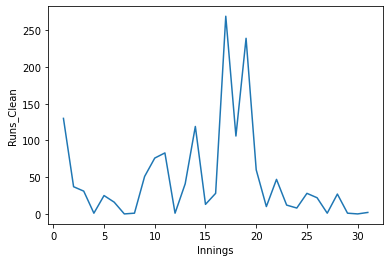

In [82]:
%matplotlib inline
sns.lineplot(data = player_nums, x = 'Innings', y = 'Runs_Clean')
plt.show()

## Calculating Posterior Distribution

Based on the post the prior distribution will have a mean of 39.15 and a standard deviation of 8.78. 

The formulas from the textbook are found below here. The new posterior mean and standard error are calculated using the original prior function with the new likelihood function. 

$$\mu_n = \frac{\displaystyle \frac{1}{\tau_{0}^2}\mu_0 + \frac{n}{\sigma^2}\bar{y}}{\displaystyle \frac{1}{\tau_{0}^2} + \frac{n}{\sigma^2}}$$
$$$$
$$\frac{1}{\tau_{n}^2} = \frac{1}{\tau_{0}^2}+ \frac{n}{\sigma^2}$$

In [83]:
# defining the prior mean and standard deviations, and prior distribution, will also define a distribution size variable
prior_mean = 39.15
prior_std = 8.78
dist_size = 100000
prior = np.random.normal(prior_mean, prior_std, size = dist_size)
# define the likelihood dataframe to store the relevant columns
l_df = stats[["var", "Dismissal","Avg", "std_err"]]
l_df["Avg"] = l_df["Avg"].astype('float64') # converting average column to float
size = len(l_df)
# define a likelihood array to contain the likelihood distribution
l_array = np.zeros(shape = (size, dist_size))
# define the posterior dataframe to store the posterior mean and standard deviations
# need to know likelihood size to determine size of the empty dataframe
pos_df = pd.DataFrame(np.nan,index = range(size), columns = ["pos_mean","pos_std"])
pos_array = np.zeros(shape = (size, dist_size))

C:\Users\krish\AppData\Local\Temp/ipykernel_7512/2945930370.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l_df["Avg"] = l_df["Avg"].astype('float64') # converting average column to float


In [84]:
# creating a for loop to iterate over the different likelihood values

for i in range(size):
    l_var, l_n, l_avg, l_std_err = l_df.loc[i,"var"], l_df.loc[i,'Dismissal'], l_df.loc[i,'Avg'], l_df.loc[i,'std_err'] # assigning values from dataframe to own variables
    l_array[i] = np.random.normal(l_avg, l_std_err, size = dist_size)
    pos_df.loc[i, 'pos_mean'] = ((prior_mean / (prior_std) ** 2) + ((l_n * l_avg) / l_var)) / (prior_std ** -2 + (l_n / l_var)) # calculating the posterior mean
    pos_df.loc[i, 'pos_std'] = (prior_std ** (-2) + (l_n / l_var)) ** (-0.5) # calculating the posterior standard error
    pos_array[i] = np.random.normal(pos_df.loc[i, 'pos_mean'],pos_df.loc[i, 'pos_std'], size = dist_size) # calculating posterior distribution
    

In [85]:
df_concat = pd.concat([pos_df, l_df, stats[['Runs_Clean']]], axis = 1) #concatenating the posterior and likelihood statistics into one dataframe

## Visualising Posterior Distribution

Plotting the data using seaborn and matplotlib libraries

In [86]:
from matplotlib import animation
%matplotlib qt

In [94]:
fig, ax1 = plt.subplots(1,1, figsize = (10,112))


def animate(i):
    ax1.cla()
    ax1.set_xlim([0,200])
    ax1.set_xlabel("Runs")
    ax1.set_ylabel("Relative Probability")
    sns.kdeplot(l_array[i], label = 'Likelihood', shade = True, ax = ax1)
    sns.kdeplot(pos_array[i], label = 'Posterior', shade = True, ax = ax1)
    sns.kdeplot(prior, label = 'Prior', shade = True, ax = ax1)
    ax1.set(title = "Dismissal: " +str(df_concat.loc[i,"Dismissal"]))
    ax1.legend(["Likelihood","Posterior","Prior"])
    
anim = animation.FuncAnimation(fig, animate, frames = len(l_array), interval = 500)

plt.show()

In [95]:
# Saves the animation as a gif
# can comment it out if taking too long to run
writergif = animation.PillowWriter(fps=5) 
anim.save('Adam Voges.gif', writer=writergif)

In [37]:
import arviz

In [40]:
hpd = arviz.hdi(pos_array[-1], hdi_prob = 0.9)
hpd

array([34.33016542, 58.35274451])

In [42]:
arviz.plot_posterior(pos_array[-1], hdi_prob = 0.9)

<AxesSubplot:title={'center':'x'}>

In [48]:
print("There is a 90% probability that the players average exists within {:.2f} and {:.2f}. This results in a bayesian average of {:.2f} with a standard error of {:.2f}"\
     .format(round(hpd[0],2),round(hpd[1],2),round(pos_df['pos_mean'].iloc[-1],2), round(pos_df['pos_std'].iloc[-1],2)))

There is a 90% probability that the players average exists within 34.33 and 58.35. Also has a bayesian average of 46.11 with a standard error of 7.31


As we can see Adam Voges bayesian average is very different compared to the classical average. The bayesian average takes into account the small sample size and extreme scores resulting in the lower average. The large standard error coupled with the wide range of the 90% probability reflects that during Voges' short career he scored at both extremes causing the wide range for the 90% interval. 